<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [46]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [47]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 393, '日付': '2021-02-01T08:00:00.000Z'},
 {'小計': 556, '日付': '2021-02-02T08:00:00.000Z'},
 {'小計': 676, '日付': '2021-02-03T08:00:00.000Z'},
 {'小計': 734, '日付': '2021-02-04T08:00:00.000Z'},
 {'小計': 577, '日付': '2021-02-05T08:00:00.000Z'},
 {'小計': 639, '日付': '2021-02-06T08:00:00.000Z'},
 {'小計': 429, '日付': '2021-02-07T08:00:00.000Z'},
 {'小計': 276, '日付': '2021-02-08T08:00:00.000Z'},
 {'小計': 412, '日付': '2021-02-09T08:00:00.000Z'},
 {'小計': 491, '日付': '2021-02-10T08:00:00.000Z'},
 {'小計': 434, '日付': '2021-02-11T08:00:00.000Z'},
 {'小計': 307, '日付': '2021-02-12T08:00:00.000Z'},
 {'小計': 369, '日付': '2021-02-13T08:00:00.000Z'},
 {'小計': 371, '日付': '2021-02-14T08:00:00.000Z'},
 {'小計': 266, '日付': '2021-02-15T08:00:00.000Z'}]

In [48]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [49]:
keys = ['contacts', 'querents', 'patients_summary']

In [50]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-02-11 17:00:00+09:00,332,0,434,2021-02-11 17:00:00+09:00
2021-02-12 17:00:00+09:00,311,0,307,2021-02-12 17:00:00+09:00
2021-02-13 17:00:00+09:00,241,0,369,2021-02-13 17:00:00+09:00
2021-02-14 17:00:00+09:00,249,0,371,2021-02-14 17:00:00+09:00


In [51]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-02-11 17:00:00+09:00,332,0,434,2021-02-11 17:00:00+09:00,323.857143,2267.0,0.0,0.0,465.428571,3258.0
2021-02-12 17:00:00+09:00,311,0,307,2021-02-12 17:00:00+09:00,320.428571,2243.0,0.0,0.0,426.857143,2988.0
2021-02-13 17:00:00+09:00,241,0,369,2021-02-13 17:00:00+09:00,301.428571,2110.0,0.0,0.0,388.285714,2718.0
2021-02-14 17:00:00+09:00,249,0,371,2021-02-14 17:00:00+09:00,295.428571,2068.0,0.0,0.0,380.000000,2660.0
2021-02-15 17:00:00+09:00,0,0,266,2021-02-15 17:00:00+09:00,248.000000,1736.0,0.0,0.0,378.571429,2650.0


In [52]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-02-01 17:00:00+09:00,432,0,393,2021-02-01 17:00:00+09:00,451.714286,3162.0,0.0,0.0,819.285714,5735.0,'21w05,Mon
2021-02-02 17:00:00+09:00,369,0,556,2021-02-02 17:00:00+09:00,431.428571,3020.0,0.0,0.0,752.142857,5265.0,'21w05,Tue
2021-02-03 17:00:00+09:00,337,0,676,2021-02-03 17:00:00+09:00,406.000000,2842.0,0.0,0.0,709.285714,4965.0,'21w05,Wed
2021-02-04 17:00:00+09:00,331,0,734,2021-02-04 17:00:00+09:00,388.428571,2719.0,0.0,0.0,662.000000,4634.0,'21w05,Thu
2021-02-05 17:00:00+09:00,335,0,577,2021-02-05 17:00:00+09:00,379.000000,2653.0,0.0,0.0,620.000000,4340.0,'21w05,Fri
2021-02-06 17:00:00+09:00,374,0,639,2021-02-06 17:00:00+09:00,368.857143,2582.0,0.0,0.0,601.285714,4209.0,'21w05,Sat
2021-02-07 17:00:00+09:00,291,0,429,2021-02-07 17:00:00+09:00,352.714286,2469.0,0.0,0.0,572.000000,4004.0,'21w05,Sun
2021-02-08 17:00:00+09:00,332,0,276,2021-02-08 17:00:00+09:00,338.428571,2369.0,0.0,0.0,555.285714,3887.0,'21w06,Mon
2021-02-09 17:00:00+09:00,273,0,412,2021-02-09 17:00:00+09:00,324.714286,2273.0,0.0,0.0,534.714286,3743.0,'21w06,Tue
2021-02-10 17:00:00+09:00,330,0,491,2021-02-10 17:00:00+09:00,323.714286,2266.0,0.0,0.0,508.285714,3558.0,'21w06,Wed


In [53]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [54]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-01-31 17:00:00+09:00,851.571429,5961
2021-02-07 17:00:00+09:00,572.000000,4004
2021-02-14 17:00:00+09:00,380.000000,2660
2021-02-15 17:00:00+09:00,266.000000,266
2021-01-03 17:00:00+09:00,816.000000,2448


In [55]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-02-01 17:00:00+09:00,432,0,393,2021-02-01 17:00:00+09:00,451.714286,3162.0,0.0,0.0,819.285714,5735.0,'21w05,Mon,NaN,NaN
2021-02-02 17:00:00+09:00,369,0,556,2021-02-02 17:00:00+09:00,431.428571,3020.0,0.0,0.0,752.142857,5265.0,'21w05,Tue,NaN,NaN
2021-02-03 17:00:00+09:00,337,0,676,2021-02-03 17:00:00+09:00,406.000000,2842.0,0.0,0.0,709.285714,4965.0,'21w05,Wed,NaN,NaN
2021-02-04 17:00:00+09:00,331,0,734,2021-02-04 17:00:00+09:00,388.428571,2719.0,0.0,0.0,662.000000,4634.0,'21w05,Thu,NaN,NaN
2021-02-05 17:00:00+09:00,335,0,577,2021-02-05 17:00:00+09:00,379.000000,2653.0,0.0,0.0,620.000000,4340.0,'21w05,Fri,NaN,NaN
2021-02-06 17:00:00+09:00,374,0,639,2021-02-06 17:00:00+09:00,368.857143,2582.0,0.0,0.0,601.285714,4209.0,'21w05,Sat,NaN,NaN
2021-02-07 17:00:00+09:00,291,0,429,2021-02-07 17:00:00+09:00,352.714286,2469.0,0.0,0.0,572.000000,4004.0,'21w05,Sun,572.0,4004.0
2021-02-08 17:00:00+09:00,332,0,276,2021-02-08 17:00:00+09:00,338.428571,2369.0,0.0,0.0,555.285714,3887.0,'21w06,Mon,NaN,NaN
2021-02-09 17:00:00+09:00,273,0,412,2021-02-09 17:00:00+09:00,324.714286,2273.0,0.0,0.0,534.714286,3743.0,'21w06,Tue,NaN,NaN
2021-02-10 17:00:00+09:00,330,0,491,2021-02-10 17:00:00+09:00,323.714286,2266.0,0.0,0.0,508.285714,3558.0,'21w06,Wed,NaN,NaN


### グラフ出力

In [56]:
sns.set()
sns.set_style('whitegrid')

In [57]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [58]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

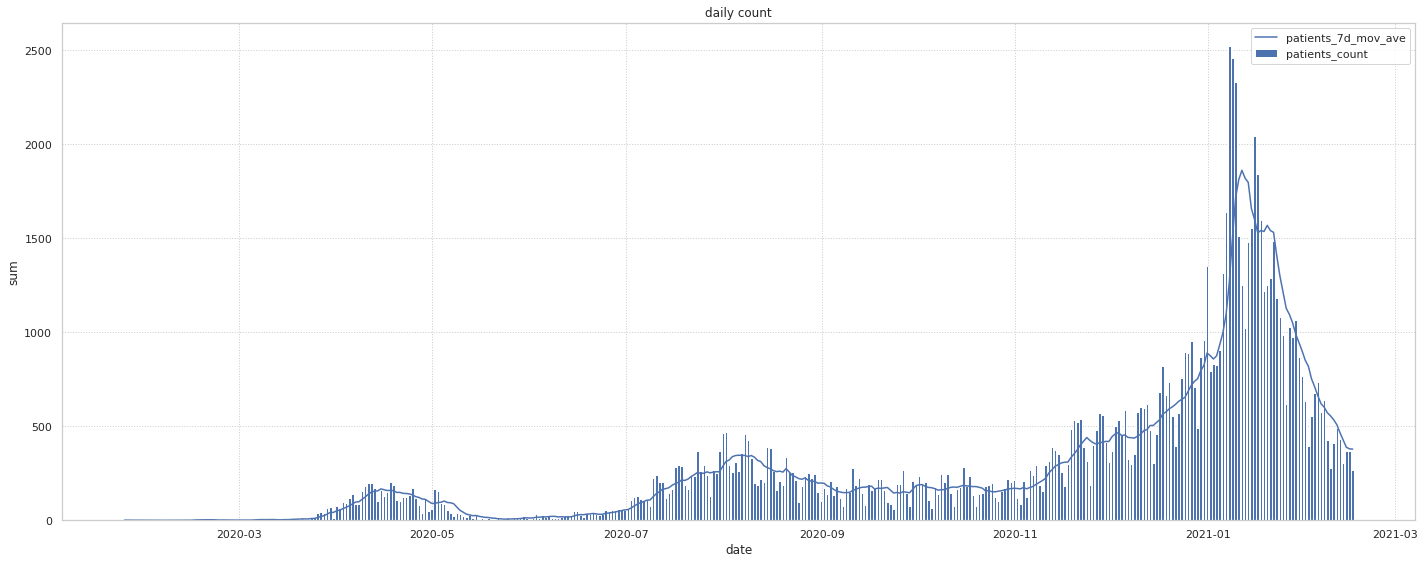

In [59]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [60]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [61]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [62]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [63]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [64]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
374,1.612166e+09,2021,2,1,0,1,0,0,0,0,0,374,0,300,432,451.714286,3162.0,0,0.0,0.0,393,819.285714,5735.0
375,1.612253e+09,2021,2,2,0,0,0,0,0,1,0,375,0,301,369,431.428571,3020.0,0,0.0,0.0,556,752.142857,5265.0
376,1.612339e+09,2021,2,3,0,0,0,0,0,0,1,376,0,302,337,406.000000,2842.0,0,0.0,0.0,676,709.285714,4965.0
377,1.612426e+09,2021,2,4,0,0,0,0,1,0,0,377,0,303,331,388.428571,2719.0,0,0.0,0.0,734,662.000000,4634.0
378,1.612512e+09,2021,2,5,1,0,0,0,0,0,0,378,0,304,335,379.000000,2653.0,0,0.0,0.0,577,620.000000,4340.0
379,1.612598e+09,2021,2,6,0,0,1,0,0,0,0,379,0,305,374,368.857143,2582.0,0,0.0,0.0,639,601.285714,4209.0
380,1.612685e+09,2021,2,7,0,0,0,1,0,0,0,380,0,306,291,352.714286,2469.0,0,0.0,0.0,429,572.000000,4004.0
381,1.612771e+09,2021,2,8,0,1,0,0,0,0,0,381,0,307,332,338.428571,2369.0,0,0.0,0.0,276,555.285714,3887.0
382,1.612858e+09,2021,2,9,0,0,0,0,0,1,0,382,0,308,273,324.714286,2273.0,0,0.0,0.0,412,534.714286,3743.0
383,1.612944e+09,2021,2,10,0,0,0,0,0,0,1,383,0,309,330,323.714286,2266.0,0,0.0,0.0,491,508.285714,3558.0


In [65]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            389 non-null    float64
 1   year                 389 non-null    int64  
 2   month                389 non-null    int64  
 3   day                  389 non-null    int64  
 4   Fri                  389 non-null    uint8  
 5   Mon                  389 non-null    uint8  
 6   Sat                  389 non-null    uint8  
 7   Sun                  389 non-null    uint8  
 8   Thu                  389 non-null    uint8  
 9   Tue                  389 non-null    uint8  
 10  Wed                  389 non-null    uint8  
 11  passed               389 non-null    int64  
 12  emergency            389 non-null    int64  
 13  em_passed            389 non-null    int64  
 14  contacts_count       389 non-null    int64  
 15  contacts_7d_mov_ave  389 non-null    flo

In [66]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,1.596614e+09,2020.118252,6.226221,15.699229,0.143959,0.143959,0.143959,0.143959,0.141388,0.141388,0.141388,194.000000,0.125964,127.133676,743.789203,742.271698,5195.892031,947.349614,947.349614,6631.447301,276.629820,273.989093,1917.881748
std,9.714719e+06,0.323322,3.545032,8.901496,0.351500,0.351500,0.351500,0.351500,0.348870,0.348870,0.348870,112.438872,0.332236,102.565909,459.419532,444.635607,3112.465661,880.000953,763.902856,5347.319991,387.647613,368.080534,2576.594946
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.588234e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.000000,0.000000,23.000000,439.000000,453.571429,3175.000000,0.000000,0.000000,0.000000,28.000000,28.000000,196.000000
50%,1.596614e+09,2020.000000,6.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,194.000000,0.000000,120.000000,595.000000,611.142857,4278.000000,959.000000,1034.571429,7242.000000,162.000000,165.000000,1155.000000
75%,1.604995e+09,2020.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,291.000000,0.000000,217.000000,917.000000,928.428571,6499.000000,1531.000000,1512.571429,10588.000000,315.000000,333.857143,2337.000000
max,1.613376e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,388.000000,1.000000,314.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [67]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.559292,0.427897,-0.015466,-0.005478,0.005478,-0.001826,0.001826,0.003614,-0.003614,-3.541150e-18,1.000000e+00,-0.324543,0.991037,-0.105469,-0.070212,-0.070206,-0.334093,-0.351695,-0.351695,0.676837,0.720291,0.720310
year,5.592918e-01,1.000000,-0.506849,-0.095071,0.008570,0.008570,0.008570,0.008570,-0.011513,-0.011513,-1.151266e-02,5.592918e-01,-0.139024,0.587625,-0.033319,0.021128,0.021129,-0.394746,-0.454740,-0.454740,0.710920,0.791671,0.791667
month,4.278965e-01,-0.506849,1.000000,0.005919,-0.015861,-0.003451,-0.011724,-0.007587,0.015750,0.009498,1.366612e-02,4.278965e-01,-0.184000,0.387089,-0.070676,-0.093702,-0.093697,0.085255,0.134367,0.134367,-0.074236,-0.118583,-0.118558
day,-1.546586e-02,-0.095071,0.005919,1.000000,0.009755,-0.003424,0.004813,0.001518,0.007920,-0.007849,-1.282871e-02,-1.546586e-02,-0.000229,-0.014186,-0.008041,-0.006362,-0.006366,0.016232,-0.001800,-0.001800,-0.012891,-0.000955,-0.000973
Fri,-5.477793e-03,0.008570,-0.015861,0.009755,1.000000,-0.168168,-0.168168,-0.168168,-0.166410,-0.166410,-1.664102e-01,-5.477793e-03,-0.001191,-0.003895,-0.021326,-0.005010,-0.005008,0.042081,-0.003897,-0.003897,0.048966,-0.002262,-0.002272
Mon,5.477793e-03,0.008570,-0.003451,-0.003424,-0.168168,1.000000,-0.168168,-0.168168,-0.166410,-0.166410,-1.664102e-01,5.477793e-03,-0.001191,0.005756,0.035125,-0.003855,-0.003854,0.176380,-0.003897,-0.003897,-0.102070,0.000588,0.000591
Sat,-1.825931e-03,0.008570,-0.011724,0.004813,-0.168168,-0.168168,1.000000,-0.168168,-0.166410,-0.166410,-1.664102e-01,-1.825931e-03,-0.001191,-0.000678,0.047813,-0.004442,-0.004441,-0.210884,-0.003897,-0.003897,0.052976,-0.001214,-0.001222
Sun,1.825931e-03,0.008570,-0.007587,0.001518,-0.168168,-0.168168,-0.168168,1.000000,-0.166410,-0.166410,-1.664102e-01,1.825931e-03,-0.001191,0.002539,-0.018820,-0.003855,-0.003854,-0.194562,-0.003897,-0.003897,-0.033087,-0.000165,-0.000166
Thu,3.613687e-03,-0.011513,0.015750,0.007920,-0.166410,-0.166410,-0.166410,-0.166410,1.000000,-0.164671,-1.646707e-01,3.613687e-03,0.001601,0.001991,-0.006985,0.006547,0.006548,0.057386,0.005235,0.005235,0.074103,0.002323,0.002330
Tue,-3.613687e-03,-0.011513,0.009498,-0.007849,-0.166410,-0.166410,-0.166410,-0.166410,-0.164671,1.000000,-1.646707e-01,-3.613687e-03,0.001601,-0.004491,-0.022825,0.004976,0.004977,0.076804,0.005235,0.005235,-0.039233,-0.000327,-0.000323


---

In [68]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [69]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,1.613030e+09,0,0,0,0,1,0,0,384,0,310,332,0,434,465.428571,3258.0
385,1.613117e+09,1,0,0,0,0,0,0,385,0,311,311,0,307,426.857143,2988.0
386,1.613203e+09,0,0,1,0,0,0,0,386,0,312,241,0,369,388.285714,2718.0
387,1.613290e+09,0,0,0,1,0,0,0,387,0,313,249,0,371,380.000000,2660.0


In [70]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
384,1.613030e+09,384,0,434,465.428571,3258.0
385,1.613117e+09,385,0,307,426.857143,2988.0
386,1.613203e+09,386,0,369,388.285714,2718.0
387,1.613290e+09,387,0,371,380.000000,2660.0


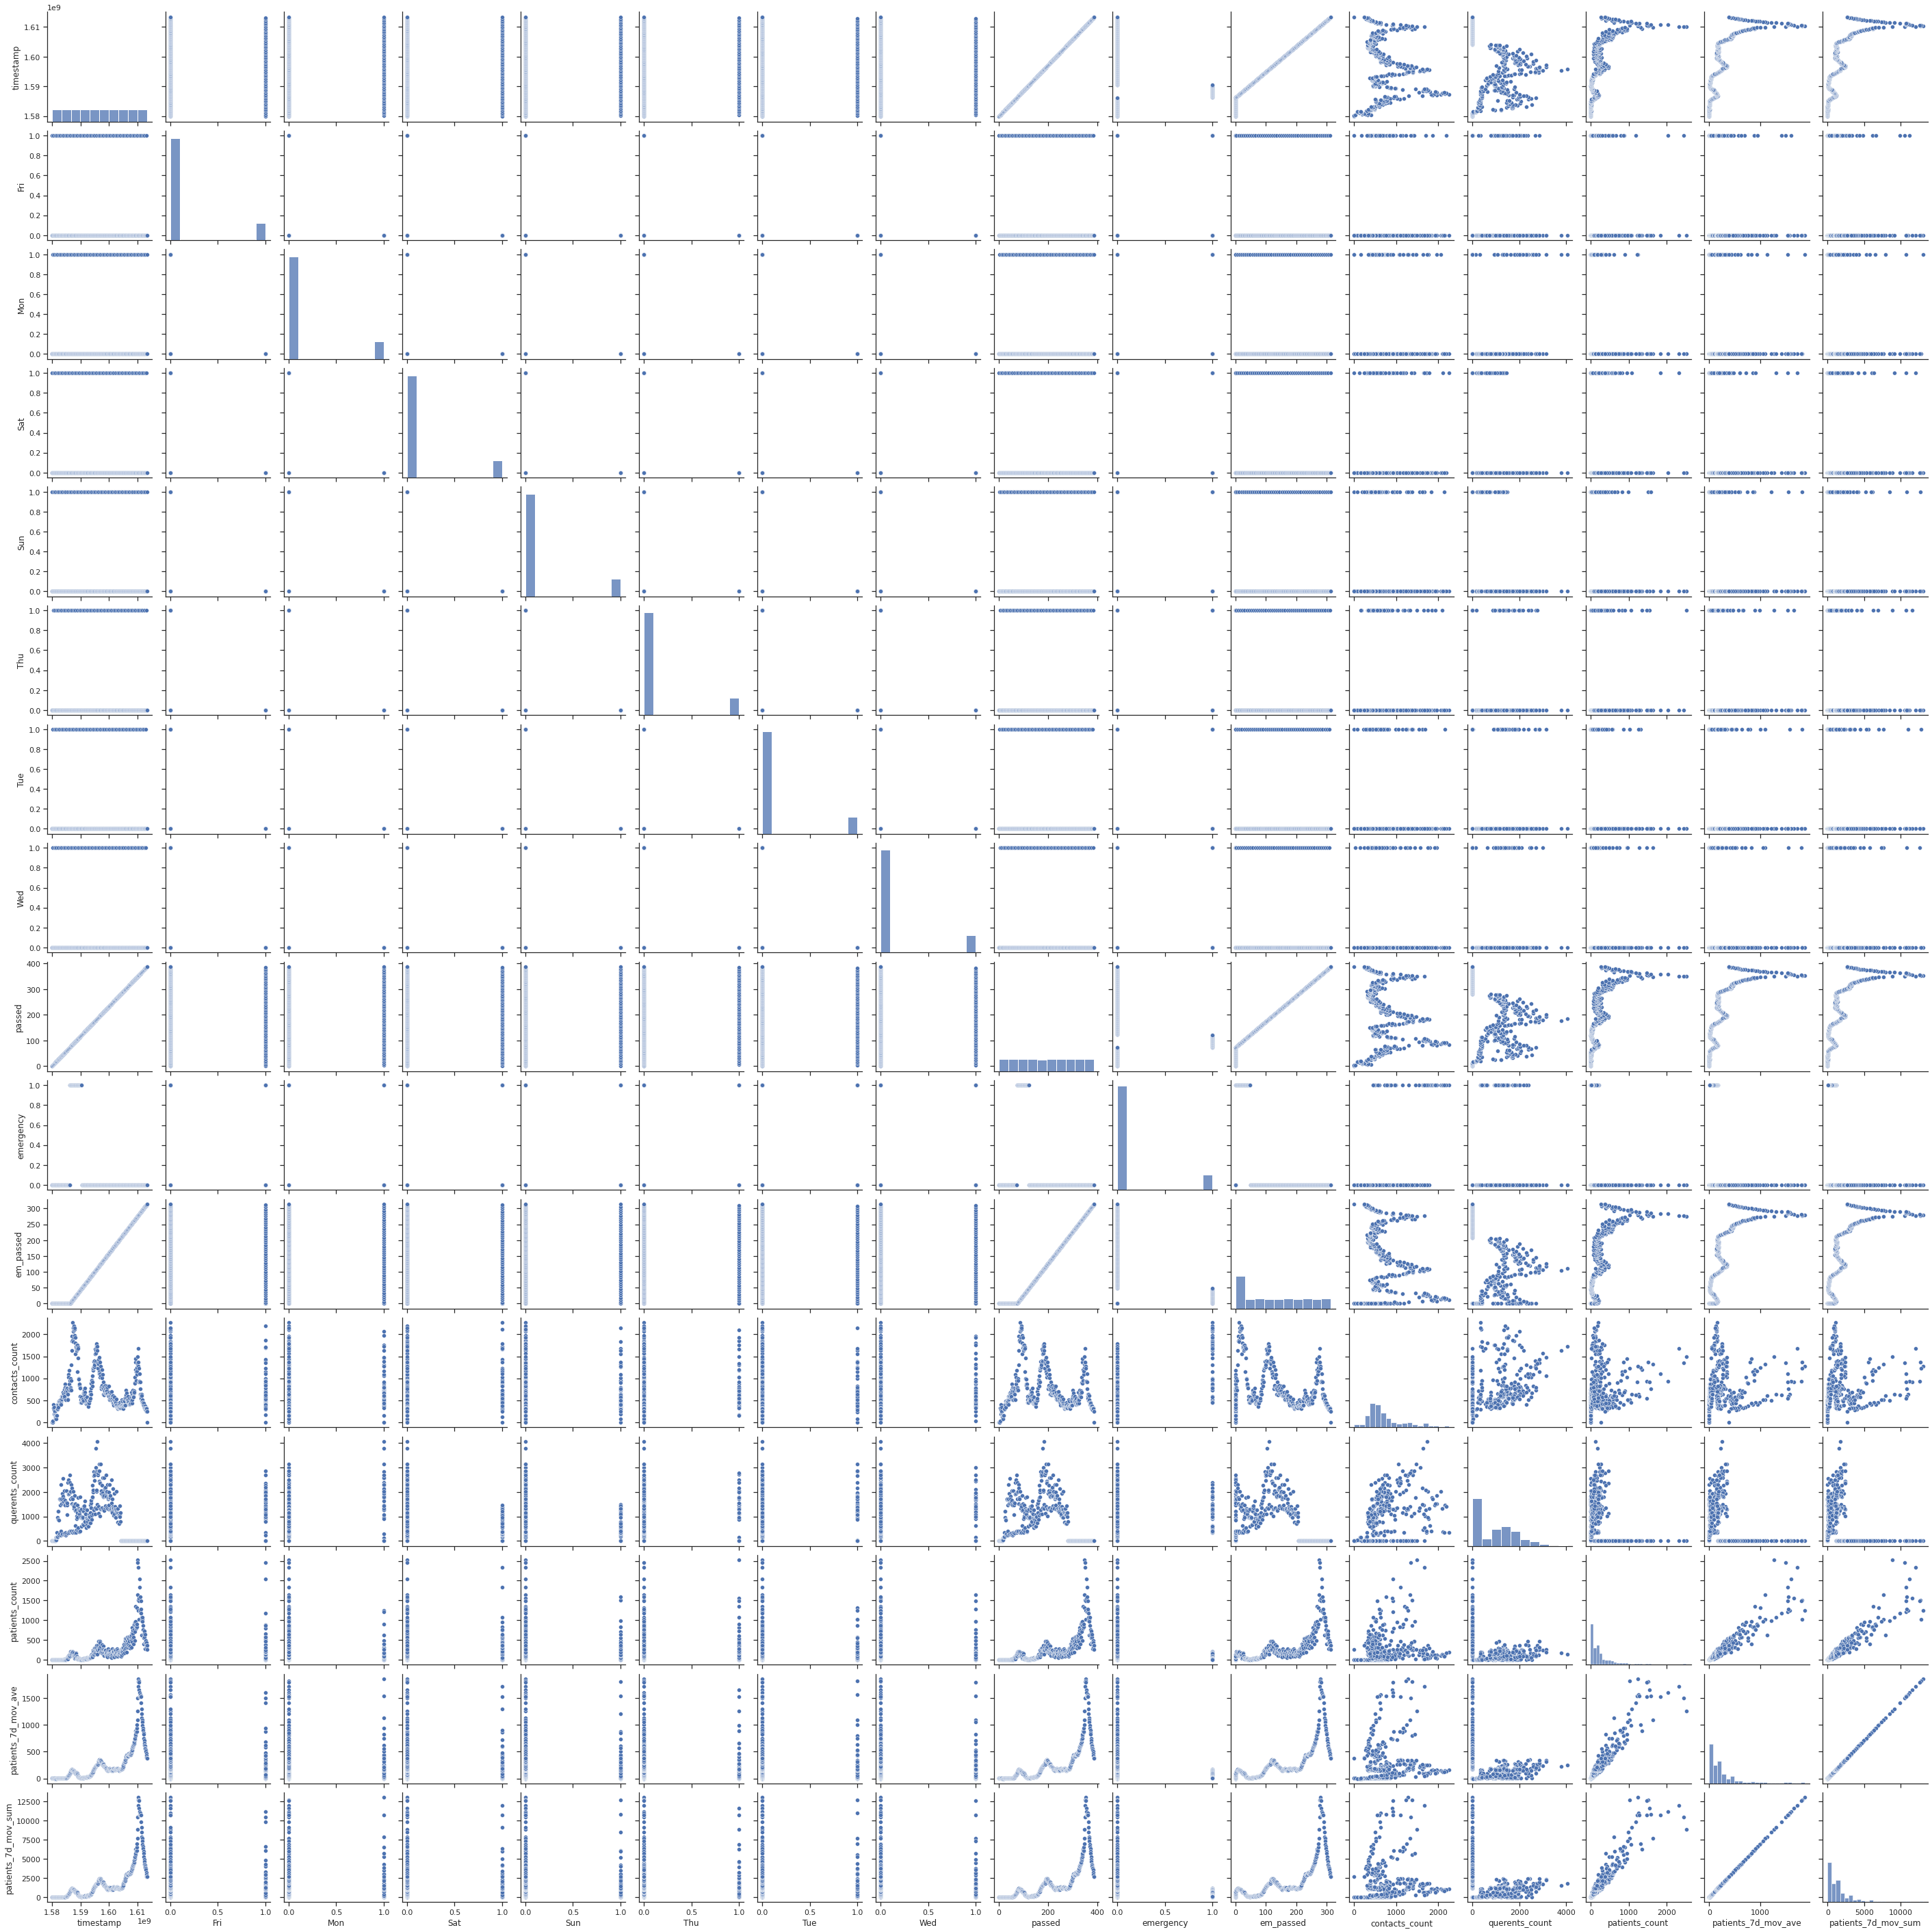

In [71]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

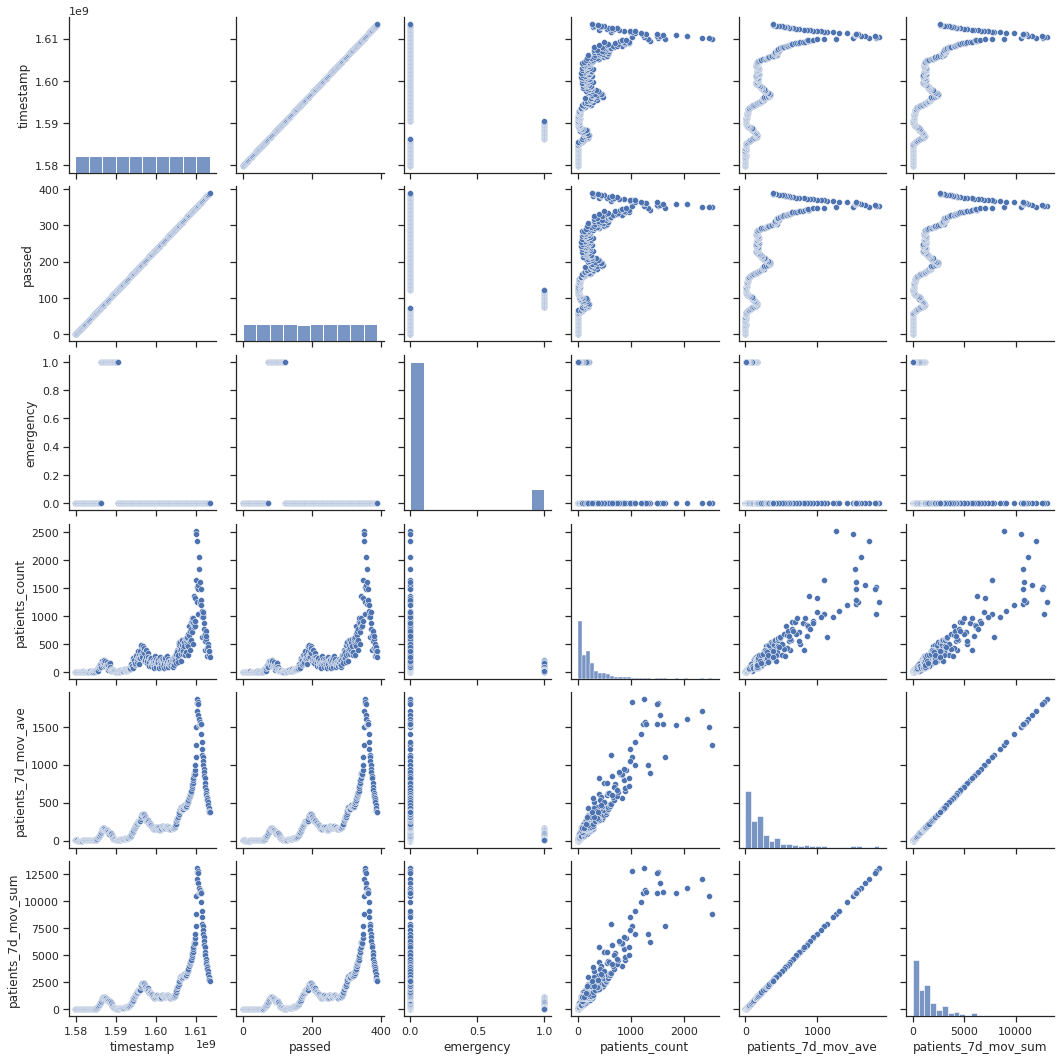

In [72]:
sns.pairplot(data=_df2)

In [73]:
!python -V

Python 3.6.9
